In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier

# Imbalanced Data Handling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer

# Classification Models
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression

# Metrics & Evaluation
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from yellowbrick.target import ClassBalance

warnings.filterwarnings("ignore")


In [127]:
# Load preprocessed datasets
train_data = pd.read_parquet("train.parquet")
val_data = pd.read_parquet("val.parquet")
test_data = pd.read_parquet("test.parquet")

In [128]:
# Define feature columns and target column
feature_cols = [col for col in train_data.columns if col != 'target']
target_col = 'target'
# Split features and target
X_train, y_train = train_data[feature_cols], train_data[target_col]
X_val, y_val = val_data[feature_cols], val_data[target_col]
X_test, y_test = test_data[feature_cols], test_data[target_col]

In [129]:
def balance_classes(X, y, strategy='smote'):
    if strategy == 'smote':
        sampler = SMOTE(random_state=42)
    elif strategy == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    else:
        raise ValueError("Invalid strategy. Choose 'smote' or 'undersample'.")

    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"Class distribution after {strategy}:\n{np.bincount(y_resampled)}")
    return X_resampled, y_resampled

# Apply class balancing technique to all sets
X_train_balanced, y_train_balanced = balance_classes(X_train, y_train, strategy='smote')
X_val_balanced, y_val_balanced = balance_classes(X_val, y_val, strategy='smote')
X_test_balanced, y_test_balanced = balance_classes(X_test, y_test, strategy='smote')

Class distribution after smote:
[1339 1339]
Class distribution after smote:
[284 284]
Class distribution after smote:
[283 283]


In [130]:
def create_bagging_models(base_models):
    bagging_models = {}
    for name, model in base_models.items():
        bagging_models[f"Bagging {name}"] = BaggingClassifier(estimator=model, n_estimators=10, random_state=42)
    return bagging_models

In [131]:
# Standardization & Encoding Pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), X_train.select_dtypes(include=['number']).columns),
    ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
])

In [132]:
base_models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier()
}
models = {**base_models, **create_bagging_models(base_models)}

In [133]:
import warnings

import pandas as pd
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

# Mapping model names to their identifiers in tune_model function
model_name_mapping = {
    "Random Forest": "rf",
    "Logistic Regression": "lr",
    "Gradient Boosting": "gb",
    "AdaBoost": "ada",
    "Extra Trees": "et",
    "XGBoost": "xgb",
    "LightGBM": "lgbm",
    "CatBoost": "cat",
    "SVM": "svm",
    "KNN": "knn",
    "Bagging": "bagging"
}

# Evaluate models and store results
model_scores = []
for model_name, model in models.items():
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    scores = cross_val_score(
        pipeline, X_train_balanced, y_train_balanced, cv=5, scoring="roc_auc"
    )

    # Train model on full training set
    pipeline.fit(X_train_balanced, y_train_balanced)

    # Predictions on validation and test set
    if hasattr(pipeline.named_steps["classifier"], "predict_proba"):
        val_preds = (pipeline.named_steps["classifier"].predict_proba(X_val_balanced)[:, 1] >= 0.5).astype(int)
        test_preds = (pipeline.named_steps["classifier"].predict_proba(X_test_balanced)[:, 1] >= 0.5).astype(int)
    elif hasattr(pipeline.named_steps["classifier"], "decision_function"):
        val_preds = (pipeline.named_steps["classifier"].decision_function(X_val_balanced) >= 0).astype(int)
        test_preds = (pipeline.named_steps["classifier"].decision_function(X_test_balanced) >= 0).astype(int)
    else:
        val_preds = pipeline.predict(X_val_balanced).astype(int)
        test_preds = pipeline.predict(X_test_balanced).astype(int)

    mean_score = np.mean(scores)
    model_scores.append((model_name, mean_score, pipeline))

    print(f"{model_name} - Mean ROC-AUC: {mean_score:.3f}")
    print("\nValidation Classification Report:")
    print(classification_report(y_val_balanced, val_preds))
    print("\nTest Classification Report:")
    print(classification_report(y_test_balanced, test_preds))

    warnings.filterwarnings("ignore")

# Select top 3 models based on ROC-AUC
model_scores.sort(key=lambda x: x[1], reverse=True)
top_3_models = model_scores[:3]

print("\nTop 3 Models:")
for model_name, score, _ in top_3_models:
    print(f"{model_name}: {score:.3f}")

Logistic Regression - Mean ROC-AUC: 0.880

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.64      0.75       284
           1       0.72      0.94      0.82       284

    accuracy                           0.79       568
   macro avg       0.82      0.79      0.79       568
weighted avg       0.82      0.79      0.79       568


Test Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.59      0.73       283
           1       0.71      0.97      0.82       283

    accuracy                           0.78       566
   macro avg       0.83      0.78      0.77       566
weighted avg       0.83      0.78      0.77       566

Random Forest - Mean ROC-AUC: 0.985

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.29      0.44       284
           1       0.58      0.99      0.73       284

    a

In [134]:
def tune_model(X_train, y_train, preprocessor, model_type='rf'):
    base_pipeline = [
        ("preprocessor", preprocessor)
    ]

    # Define different models and their parameter grids
    model_configs = {
        'rf': {
            'model': RandomForestClassifier(random_state=0),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__max_depth": [None, 10, 20],
                "classifier__min_samples_split": [2, 5, 10]
            }
        },
        'lr': {
            'model': LogisticRegression(random_state=0),
            'params': {
                "classifier__C": [0.001, 0.01, 0.1, 1, 10],
                "classifier__penalty": ['l2'],
                "classifier__solver": ['lbfgs']
            }
        },
        'xgb': {
            'model': XGBClassifier(random_state=0),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__max_depth": [3, 5, 7],
                "classifier__learning_rate": [0.01, 0.1, 0.3],
                "classifier__min_child_weight": [1, 3, 5]
            }
        },
        'gb': {
            'model': GradientBoostingClassifier(random_state=0),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__learning_rate": [0.01, 0.1, 0.3],
                "classifier__max_depth": [3, 5, 7]
            }
        },
        'ada': {
            'model': AdaBoostClassifier(random_state=0),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__learning_rate": [0.01, 0.1, 0.3]
            }
        },
        'et': {
            'model': ExtraTreesClassifier(random_state=0),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__max_depth": [None, 10, 20]
            }
        },
        'lgbm': {
            'model': LGBMClassifier(random_state=0),
            'params': {
                "classifier__n_estimators": [50, 100, 200],
                "classifier__learning_rate": [0.01, 0.1, 0.3],
                "classifier__max_depth": [3, 5, 7]
            }
        },
        'cat': {
            'model': CatBoostClassifier(verbose=0, random_state=0),
            'params': {
                "classifier__iterations": [50, 100, 200],
                "classifier__learning_rate": [0.01, 0.1, 0.3],
                "classifier__depth": [3, 5, 7]
            }
        },
        'svm': {
            'model': SVC(probability=True, random_state=0),
            'params': {
                "classifier__C": [0.1, 1, 10],
                "classifier__kernel": ['linear', 'rbf']
            }
        },
        'knn': {
            'model': KNeighborsClassifier(),
            'params': {
                "classifier__n_neighbors": [3, 5, 7, 9],
                "classifier__weights": ['uniform', 'distance']
            }
        }
    }

    if model_type not in model_configs:
        raise ValueError(f"Model type {model_type} not supported. Choose from: {list(model_configs.keys())}")

    # Create the full pipeline with the selected model
    model_pipeline = Pipeline(base_pipeline + [
        ("classifier", model_configs[model_type]['model'])
    ])

    # Perform grid search
    grid_search = GridSearchCV(
        model_pipeline,
        model_configs[model_type]['params'],
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=1
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Print results
    print(f"\nBest Parameters for {model_type.upper()}:")
    print(grid_search.best_params_)
    print(f"Best ROC-AUC Score: {grid_search.best_score_:.3f}")

    return grid_search

In [135]:
best_models = {}
for model_name, _, model_pipeline in top_3_models:
    model_type = model_name_mapping.get(model_name, None)
    if model_type is None:
        print(f"Skipping tuning for {model_name} as it is not in the mapping.")
        continue
    print(f"\nTuning model: {model_name}")
    best_models[model_name] = tune_model(X_train, y_train, preprocessor, model_type=model_type)


Skipping tuning for Bagging Extra Trees as it is not in the mapping.

Tuning model: Extra Trees
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Parameters for ET:
{'classifier__max_depth': 10, 'classifier__n_estimators': 200}
Best ROC-AUC Score: 0.871

Tuning model: XGBoost
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best Parameters for XGB:
{'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 100}
Best ROC-AUC Score: 0.871


In [136]:
def plot_confusion_matrices(models, X_test, y_test):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for ax, (model_name, model) in zip(axes, models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], ax=ax)
        ax.set_title(f"{model_name} Confusion Matrix")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    plt.tight_layout()
    plt.show()

In [137]:
def plot_class_balance(y_train, y_val):
    visualizer = ClassBalance(labels=["0", "1"])
    visualizer.fit(y_train, y_val)
    visualizer.show()
    plt.show()

In [138]:
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(8, 6))
    plt.style.use('ggplot')

    for model_name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, linewidth=3, label=f"{model_name} (AUC = {auc_score:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color='black', linewidth=3)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
    plt.legend(fontsize=11, loc='lower right')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

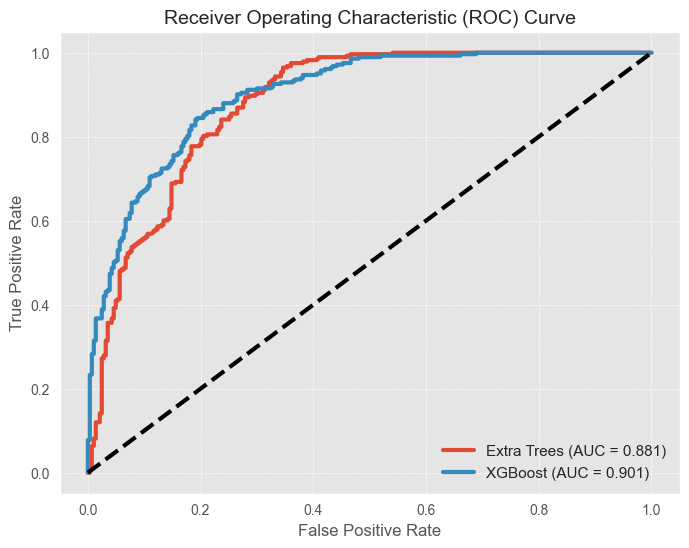

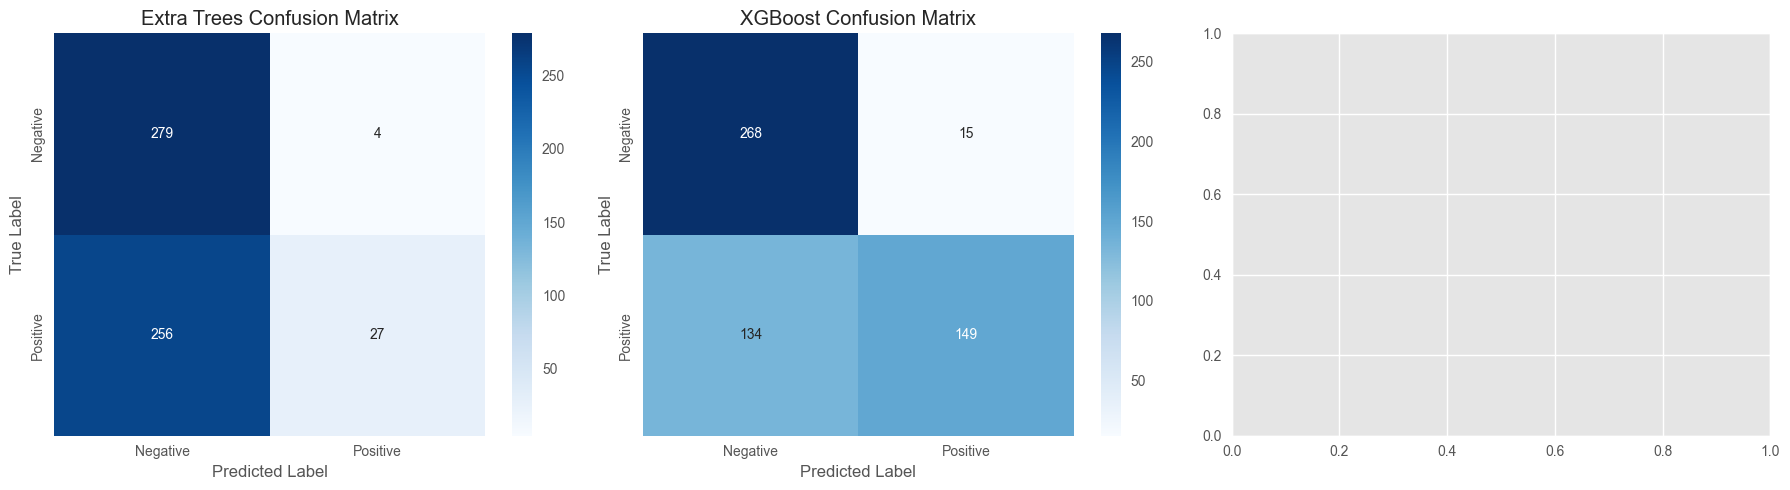

In [139]:
best_model_instances = {model_name: best_models[model_name].best_estimator_ for model_name in best_models}
plot_roc_curves(best_model_instances, X_test_balanced, y_test_balanced)
plot_confusion_matrices(best_model_instances, X_test_balanced, y_test_balanced)